In [2]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import normalized_mutual_info_score

from model.utils    import normalize, smacof_mds
from model.otkmeans import custom_kmeans

Download/Load test MNIST dataset:
- 10k images of $0, 1, 2, \dots, 9$ charcaters (28x28) 


In [4]:
test_data=datasets.MNIST(root='data', train=False, download=True, transform=ToTensor(),)

In [5]:
images = np.asarray(test_data.data)
print(images.shape)
targets = np.asarray(test_data.targets)
print(targets.shape)

(10000, 28, 28)
(10000,)


Let visualize a subset of the dataset (with resepctive labels)

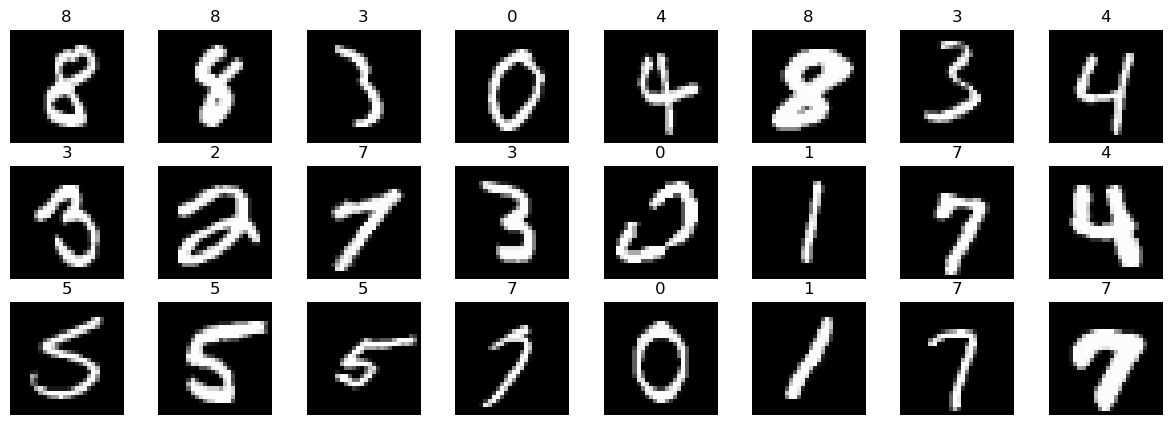

In [7]:
labels_map={
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}

figure = plt.figure(figsize = (15,5))
cols, rows = 8, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(test_data), size = (1,)).item()
    image, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

The following is a function that allow us to create a pointcloud from an image. Note that the number of points of the pointcloud correspond to the number of active pixels of the image.

In [9]:
def image_to_point_cloud(image):
    # Normalizza l'immagine
    image = image / np.max(image)
    # Trova gli indici dei pixel attivi (valori > 0)
    active_pixels = np.argwhere(image > 0)
    # Estrai i valori dei pixel corrispondenti
    pixel_values = image[active_pixels[:, 0], active_pixels[:, 1]]
    # Pondera la selezione dei punti in base all'intensità del pixel
    probabilities = pixel_values / np.sum(pixel_values)
    # Seleziona punti casuali ponderati per l'intensità
    selected_indices = np.random.choice(np.arange(len(active_pixels)),
                                        size=len(active_pixels), 
                                        replace=False, 
                                        #p=probabilities
                                       )
    selected_points = active_pixels[selected_indices]
    point_cloud = selected_points
    return point_cloud

In [10]:
characters = [0, 1, 2, 3, 4]   # characters that we want to consider
num_sample_per_class = 10
dataset, point_clouds, true_labels = [], [], []

for ch in characters:
    print('Created class', ch)
    ch_class = images[targets==ch][:num_sample_per_class].tolist()
    dataset = dataset + ch_class
    point_clouds = point_clouds + [normalize(image_to_point_cloud(image).astype(float)) for image in ch_class]
    true_labels = true_labels + [ch] * num_sample_per_class

Created class 0
Created class 1
Created class 2
Created class 3
Created class 4


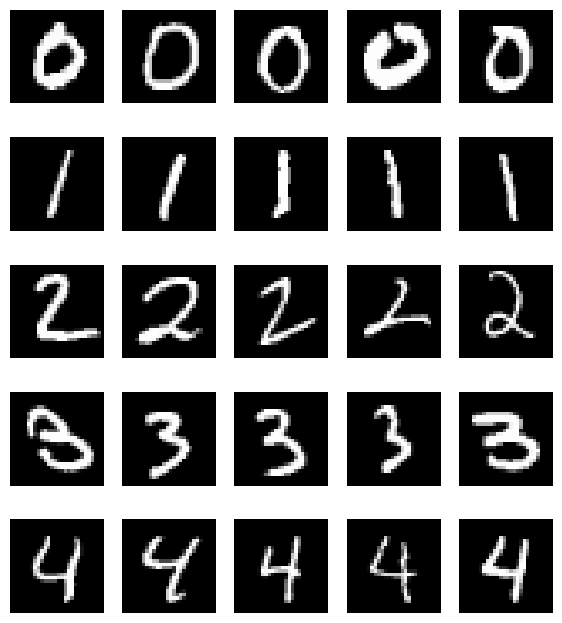

In [11]:
figure = plt.figure(figsize = (7,8))
cols, rows = 5, 5
ind = 1
for i in range(rows):
    for j in range(cols):
        image = dataset[i*10+j]
        figure.add_subplot(rows, cols, ind)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        ind+=1
plt.savefig('fig/MNIST_img.pdf', bbox_inches='tight', format="pdf")
plt.show()

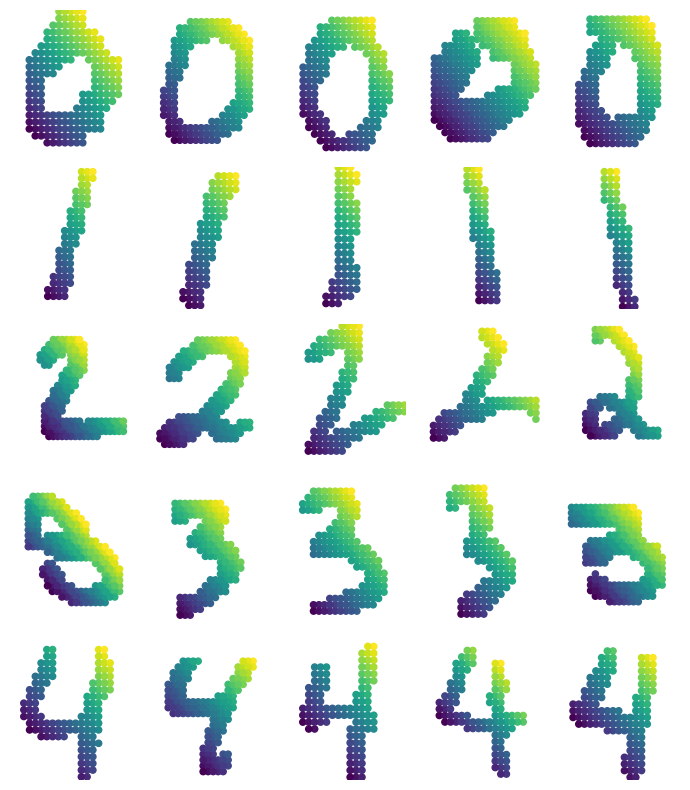

In [12]:
def get_color(pc):
    return pc[:, 1]-pc[:, 0]

fig, axs = plt.subplots(rows, cols, figsize=(7,8))
for row in range(rows):
    for col in range(cols):
        pc = point_clouds[row * 10 + col]
        axs[row, col].scatter(pc[:, 1], -pc[:, 0], c=get_color(pc), 
                              #edgecolors="k", 
                              alpha=1, s=20, cmap='viridis')
        axs[row, col].set_xlim([-1, 1])
        axs[row, col].set_ylim([-1, 1])
        axs[row, col].set_axis_off()
plt.tight_layout()
plt.savefig('fig/MNIST_pcd.pdf', bbox_inches='tight', format="pdf")
plt.show()

# Run _OT k-means_

In [14]:
dimensions = [len(pc) for pc in point_clouds]
print('Min n. of points:', np.min(dimensions))

Min n. of points: 46


In [15]:
np.sort(dimensions)

array([ 46,  60,  61,  64,  68,  75,  81,  82, 100, 101, 104, 104, 106,
       115, 120, 120, 124, 126, 127, 128, 132, 135, 136, 137, 137, 151,
       154, 157, 162, 162, 163, 165, 167, 168, 169, 169, 171, 171, 173,
       176, 179, 184, 193, 196, 199, 200, 206, 210, 215, 268])

In [16]:
num_clusters = len(characters)
num_points = 100           # should be <= then the min n. of points

In [17]:
print("Running K-means with custom OT distance...")
metric = ['wasserstein', 'gromov-wasserstein', 'gromov-wasserstein', 'procrustes-wasserstein']
names = ['EMD', 'Euc-GW', 'Geo-GW', 'PW']
list_centroids, list_predictions, list_loss, list_time = [], [], [], []

max_iter = 10

for i, mt in enumerate(metric):

    if i == 2:
        feature_metric = 'geodesic'
    else:
        feature_metric = 'euclidean'
    
    start_time = time.time()
    centroids, predicted_labels, loss, dictionary = custom_kmeans(data = point_clouds,
                                                                  num_clusters = num_clusters,
                                                                  max_iter = max_iter,
                                                                  num_points = num_points,
                                                                  ot_metric = mt,
                                                                  feature_metric = feature_metric
                                                                  )
    
    final_time = time.time()-start_time
    list_predictions.append(predicted_labels)
    list_centroids.append(centroids)
    list_time.append(final_time)
    list_loss.append(loss)

Running K-means with custom OT distance...

- iteration: 0
[0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 0. 3.
 0. 0. 4. 0. 0. 0. 4. 0. 2. 2. 0. 0. 0. 0. 2. 0. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4.]
loss value: 0.07955581510808368
Updated centroid 0
Updated centroid 1
Updated centroid 2
Updated centroid 3
Updated centroid 4
0.0158693233949517
0.01942154513639974
0.015194643310705547
0.0007743526581337817
0.019335792734290192
0

- iteration: 1
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 0. 3.
 0. 0. 4. 0. 0. 0. 4. 0. 2. 2. 4. 0. 0. 0. 2. 0. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4.]
loss value: 0.03249362497634439
Updated centroid 0
Updated centroid 1
Updated centroid 2
Updated centroid 3
Updated centroid 4
0.003337482359282508
0.0037623325357986435
0.0014064541347050597
0.00030598898972911955
0.003768115936607025
0

- iteration: 2
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 2. 2. 2. 2. 0. 2. 2. 0. 0. 0. 0. 3.
 0. 0. 4. 0. 0. 4. 4. 0. 2. 2. 4. 0. 0. 0. 2. 0. 4. 4. 4. 

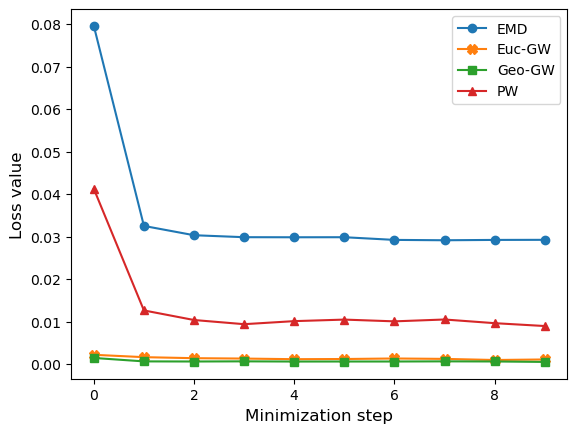

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(list_loss[0])), list_loss[0], ls='-', marker='.', linewidth=1.5, markersize=12, label=names[0])
ax.plot(np.arange(len(list_loss[1])), list_loss[1], ls='-', marker='X', linewidth=1.5, markersize=7, label=names[1])
ax.plot(np.arange(len(list_loss[2])), list_loss[2], ls='-', marker='s', linewidth=1.5, markersize=6, label=names[2])
ax.plot(np.arange(len(list_loss[3])), list_loss[3], ls='-', marker='^', linewidth=1.5, markersize=6, label=names[3])
ax.set_ylabel('Loss value', fontsize=12)
ax.set_xlabel('Minimization step', fontsize=12)
ax.legend()
plt.show()

In [19]:
print('\nClustering Results ---------- ')
print('\n-- (WASS.) --')
print('Time : ---%s seconds---' % (list_time[0]))
ari = adjusted_rand_score(true_labels, list_predictions[0])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
nmi = normalized_mutual_info_score(true_labels, list_predictions[0])
print(f"Normalized mutual info score (NMI): {nmi:.4f}")

print('\n-- (Euclidean GROMOV-WASS.) --')
print('Time : ---%s seconds---' % (list_time[1]))
ari = adjusted_rand_score(true_labels, list_predictions[1])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
nmi = normalized_mutual_info_score(true_labels, list_predictions[1])
print(f"Normalized mutual info score (NMI): {nmi:.4f}")

print('\n-- (Geodesic GROMOV-WASS.) --')
print('Time : ---%s seconds---' % (list_time[2]))
ari = adjusted_rand_score(true_labels, list_predictions[2])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
nmi = normalized_mutual_info_score(true_labels, list_predictions[2])
print(f"Normalized mutual info score (NMI): {nmi:.4f}")

print('\n-- (PROCRUSTES-WASS.) --')
print('Time : ---%s seconds---' % (list_time[3]))
ari = adjusted_rand_score(true_labels, list_predictions[3])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
nmi = normalized_mutual_info_score(true_labels, list_predictions[3])
print(f"Normalized mutual info score (NMI): {nmi:.4f}")


Clustering Results ---------- 

-- (WASS.) --
Time : ---9.175940990447998 seconds---
Adjusted Rand Index (ARI): 0.4069
Normalized mutual info score (NMI): 0.5652

-- (Euclidean GROMOV-WASS.) --
Time : ---675.1850333213806 seconds---
Adjusted Rand Index (ARI): 0.5500
Normalized mutual info score (NMI): 0.6815

-- (Geodesic GROMOV-WASS.) --
Time : ---378.815288066864 seconds---
Adjusted Rand Index (ARI): 0.3797
Normalized mutual info score (NMI): 0.5724

-- (PROCRUSTES-WASS.) --
Time : ---130.11053276062012 seconds---
Adjusted Rand Index (ARI): 0.7669
Normalized mutual info score (NMI): 0.8361


In [ ]:
list_centroids[1] = [smacof_mds(centri, 2) for centri in list_centroids[1]]
list_centroids[2] = [smacof_mds(centri, 2) for centri in list_centroids[2]]

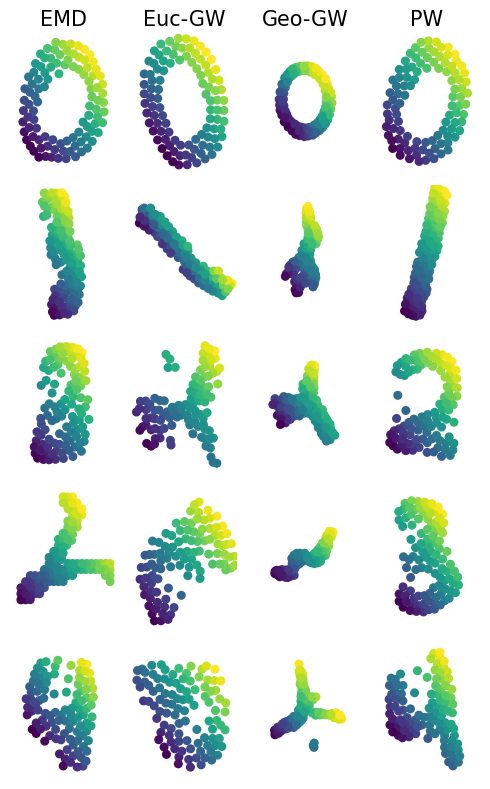

In [46]:
# Constructed by hand in order to match the clusters among algorithms
permutation = np.array([[1, 2, 0, 3, 4], 
                        [1, 0, 2, 3, 4], 
                        [1, 3, 2, 0, 4], 
                        [1, 2, 4, 3, 0]])

fig, axs = plt.subplots(num_clusters, len(metric), figsize=(5,8))
for col in range(len(metric)):
    centri = list_centroids[col]

    for row in range(num_clusters):
        
        pc = centri[permutation[col, row]]
        if col == 3:
            pc = pc @ dictionary[permutation[col, row]][1]
        
        axs[row, col].scatter(pc[:, 1], -pc[:, 0], c=get_color(pc), s=30, cmap='viridis')        

        if col == 1:
            axs[row, col].set_xlim([-.5, .5])
            axs[row, col].set_ylim([-.5, .5])
        elif col == 2:
            axs[row, col].set_xlim([-.8, .8])
            axs[row, col].set_ylim([-.8, .8])
        else:
            axs[row, col].set_xlim([-1, 1])
            axs[row, col].set_ylim([-1, 1])
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        axs[row, col].set_axis_off()
        if row==0:
            axs[row, col].set_title(names[col], fontsize=15)
plt.tight_layout()
plt.savefig('fig/MINST_centroids.pdf', bbox_inches='tight', format="pdf")
plt.show()

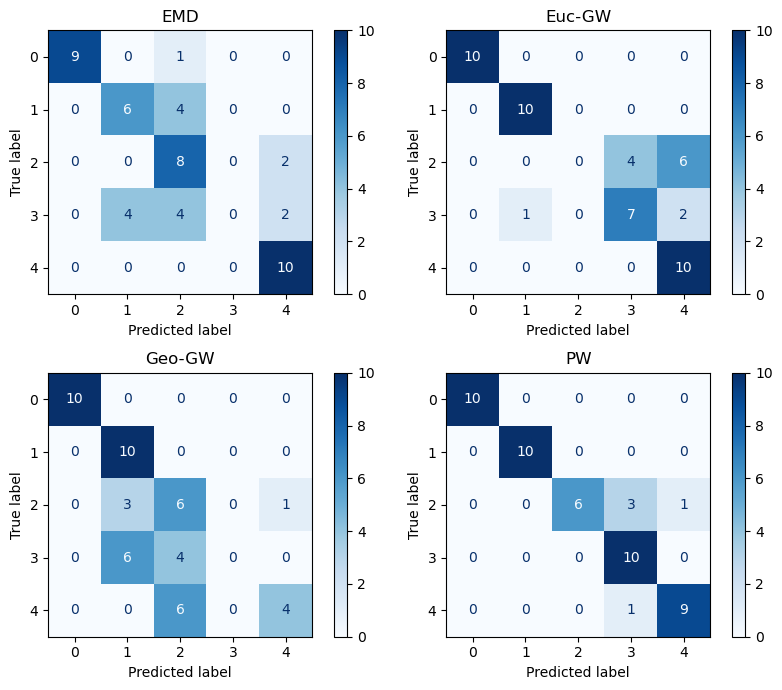

In [44]:
def match_prediction_labels(y_true, y_pred):
    y_pred_matched = np.empty_like(y_pred)
    # For each cluster label...
    for k in np.unique(y_pred):
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((y_pred==k)*(y_true==t)) for t in np.unique(y_true)]
        y_pred_matched[y_pred==k] = np.unique(y_true)[np.argmax(match_nums)]
    return y_pred_matched


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,7))
for i, ax in zip(range(4), axes.flatten()):
    pred_labels = match_prediction_labels(true_labels, list_predictions[i])
    ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, 
                                                   ax=ax, cmap='Blues')
    ax.title.set_text(names[i])
plt.tight_layout()
fig.subplots_adjust(wspace=-.1)
plt.savefig('fig/MNIST_cm.pdf', bbox_inches='tight', format="pdf")
plt.show()